# Import Model

In [32]:
import tensorflow as tf
lr = 7.0
size = 224
iterations = 1000
style_wt = 1e5
content_wt = 1.0

content_image_path = "profile_white_background.jpeg"
style_image_path = "style.jpeg"

from tensorflow.python.keras.applications.vgg19 import VGG19

In [4]:
model = VGG19(
    include_top =False,
    weights = 'imagenet'
)

model.trainable = False
model.summary()

80142336/80134624 [==============================] - 3687s 46us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
__________________________________________________________

# Import Libraries and Helper Function

In [9]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Image Processing and Display

In [10]:
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(size, size))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return np.expand_dims(img, axis = 0)

In [11]:
def deprocess(x):
    #Opposite of preprocess_input()
    x[:,:,0] += 103.939
    x[:,:,1] += 116.779
    x[:,:,2] += 123.68
    x = x[:,:,::-1]     # change order of channels
    x = np.clip(x, 0, 255).astype('uint8')    # scale values between 0 to 255
    return x

def display_image(image):
    if len(image.shape) == 4:
        img = np.squeeze(image, axis = 0)   # opposite of expand_dims()
    img = deprocess(img)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

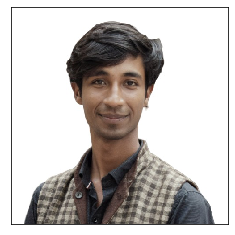

In [12]:
#Content Image
display_image(preprocess_image(content_image_path))

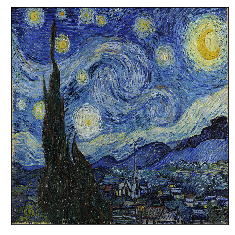

In [13]:
# Style Image
display_image(preprocess_image(style_image_path))

# Content and style Models

In [14]:
content_layer = 'block5_conv2'       # deep layer

# shallow layer
style_layers = [
    'block1_conv1',
    'block3_conv1',
    'block5_conv1'
]

content_Model = tf.keras.models.Model(
    inputs=model.input,
    outputs=model.get_layer(content_layer).output
)

style_models = [
    tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(layer).output)
    for layer in style_layers
]

# Content Cost

In [23]:
def content_cost(content_img, generated_img):
    C = content_Model(content_img)
    G = content_Model(generated_img)
    cost = tf.reduce_mean(tf.square(C - G))
    return cost

# Gram Matrix

In [20]:
# It is used to calculate the style cost. It gives strong correlation.
# It maps feature distribution.

def gram_matrix(M):
    num_channels = tf.shape(M)[-1]
    M = tf.reshape(M, shape=(-1, num_channels))
    n = tf.shape(M)[0]
    G = tf.matmul(tf.transpose(M), M)
    return G / tf.cast(n, dtype=tf.float32)

# Style Cost

In [21]:
def style_cost(style_img, generated_img):
    total_cost = 0
    
    for i, style_model in enumerate(style_models):
        S = style_model(style_img)
        G = style_model(generated_img)
        GS = gram_matrix(S)
        GG = gram_matrix(G)
        current_cost = style_layer_wts[i] * tf.reduce_mean(tf.square(GS - GG))
        total_cost += current_cost
    
    total_cost /= (size * size * len(style_models))
    return total_cost

# Training Loop

Iteration:1/1000, Total Cost:635156864.0, Style Cost: 6351.568359375, Content Cost: 0.0
Iteration:6/1000, Total Cost:120700072.0, Style Cost: 1206.9404296875, Content Cost: 6034.59814453125
Iteration:11/1000, Total Cost:63737760.0, Style Cost: 637.3076782226562, Content Cost: 6991.29736328125
Iteration:16/1000, Total Cost:42581304.0, Style Cost: 425.740478515625, Content Cost: 7255.5673828125
Iteration:21/1000, Total Cost:29301172.0, Style Cost: 292.9375, Content Cost: 7422.2578125
Iteration:26/1000, Total Cost:21552706.0, Style Cost: 215.4536590576172, Content Cost: 7339.92236328125
Iteration:31/1000, Total Cost:16471758.0, Style Cost: 164.6439971923828, Content Cost: 7358.11181640625
Iteration:36/1000, Total Cost:13250454.0, Style Cost: 132.4300079345703, Content Cost: 7452.5205078125
Iteration:41/1000, Total Cost:11100634.0, Style Cost: 110.93043518066406, Content Cost: 7590.275390625
Iteration:46/1000, Total Cost:9542413.0, Style Cost: 95.34687042236328, Content Cost: 7726.38818359

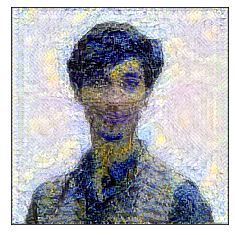

In [31]:
style_layer_wts = [1.0, 0.8, 0.1, 0.1, 0.2]

content_image_preprocessed = preprocess_image(content_image_path)
style_image_preprocessed = preprocess_image(style_image_path)
generated_image = tf.Variable(content_image_preprocessed, dtype=tf.float32)

generated_images = []
costs = []

optimizer = tf.optimizers.Adam(learning_rate=lr)

for i in range(iterations):
    
    with tf.GradientTape() as tape:
        J_content = content_cost(content_img=content_image_preprocessed, generated_img=generated_image)
        J_style = style_cost(style_img=style_image_preprocessed, generated_img=generated_image)
        J_total = content_wt * J_content + style_wt * J_style
    
    gradients = tape.gradient(J_total, generated_image)
    optimizer.apply_gradients([(gradients, generated_image)])
    
    costs.append(J_total.numpy())
    
    if i % 100 == 0:
        display_image(generated_image.numpy())
        generated_images.append(generated_image.numpy())
        print("Iteration:{}/{}, Total Cost:{}, Style Cost: {}, Content Cost: {}".format(i+1, iterations, J_total, J_style, J_content))

# Plotting

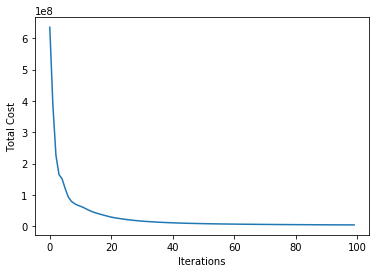

In [33]:
plt.plot(range(iterations), costs)
plt.xlabel("Iterations")
plt.ylabel("Total Cost")
plt.show()

In [34]:
from PIL import Image
image = Image.fromarray(deprocess(generated_images[-1][0]))

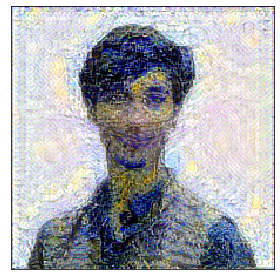

In [35]:
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('out.png')